In [9]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime
from scipy.integrate import odeint, solve_ivp

In [10]:
import sys 
path = 'C:/Users/Tomas/PhD_Physics/3rd_Year/Max-Ent_Library'
sys.path.insert(1, path) 

import a_quantum_geometries as gij
import b_spin_ops as su2
import c_maxent_tools as me

In [11]:
params={}

params['size']=6
params['beta']=5.

params['omega']=.5*np.pi*2.; 

params['Jx']=5*10**-1*params['omega']; params['Jy'] = .5*params['Jx']; params['chain_type']='XY'

In [12]:
spin_ops=su2.one_body_spin_ops(args=params)

idop=spin_ops['idop']
sx_total=sum(sx for sx in spin_ops['sx'])
sy_total=sum(sx for sx in spin_ops['sy'])
sz_total=sum(sx for sx in spin_ops['sz'])

In [13]:
H0=params['omega']*sz_total
Hint=1.*su2.Heisenberg_1D_Hamiltonian(spin_ops=spin_ops, args=params)
HXY=H0+Hint

In [14]:
HBB0=[idop, sx_total, sy_total, spin_ops['sx'][1]*spin_ops['sx'][2], sz_total]
phi0=[10., 1., 1., -3, -5.]
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)
phi0[0]=np.log(sigma0.tr())
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)
#HBB0+=[K0]

qutip.expect(spin_ops['sz'], sigma0)

array([4.92160769e-01, 1.42572586e-17, 1.62630326e-19, 5.42101086e-20,
       0.00000000e+00, 0.00000000e+00])

In [15]:
N=200
T=1*np.pi/max(.01,abs(params['Jx']))/N
timespan = np.linspace(0,N*T,N)

resex_XY=qutip.mesolve(H=HXY,
                        rho0=K0,
                        tlist=timespan,
                        args=params)
rhos_XY=[gij.safe_expm_and_normalize(K=Kti) for Kti in resex_XY.states]

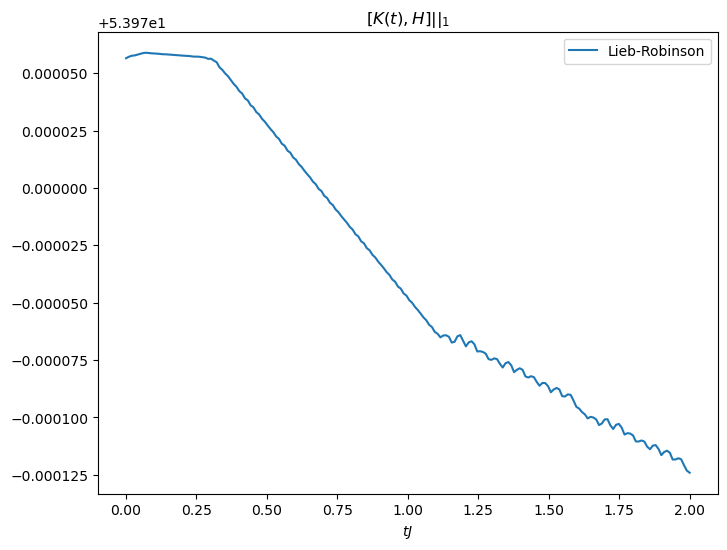

In [8]:
#Ut=lambda t: (-1j*HXX*t).expm()
#propagators=[Ut(t=ti) for ti in timespan]
Kt=resex_XY.states
Ob=HXY

lieb_robinson=np.array([linalg.norm(gij.commutator(Kti,Ob)) for Kti in Kt])

fig,ax0=plt.subplots(figsize=(8,6))
plt.plot(timespan, lieb_robinson, label='Lieb-Robinson')
plt.title(f'$[K(t), H]||_1$')
plt.xlabel(f'$tJ$')
ax0.legend(loc=0)
plt.plot()
plt.show()

basis_Ks=HBB0+[Kt_ex_ti for Kt_ex_ti in exact_Ks_rotframe[:10] if exact_Ks_rotframe.index(Kt_ex_ti)%5==0]
phi0+=[.0 for i in range(len(basis_Ks) -len(HBB0))]

In [22]:
ell=3
vLR=2*params['Jx']
tcut= ell/vLR
tcut

0.954929658551372

In [23]:
HBB0=[idop, sx_total, sy_total, spin_ops['sx'][1]*spin_ops['sx'][2], sz_total]
phi0=[10., 1., 1., -3, -5.]
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)
phi0[0]=np.log(sigma0.tr())
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)
#HBB0+=[K0]

qutip.expect(spin_ops['sz'], sigma0)
len(phi0)

array([4.92160769e-01, 1.42572586e-17, 1.62630326e-19, 5.42101086e-20,
       0.00000000e+00, 0.00000000e+00])

In [24]:
def func_restricted_ev(t,y,generator, basis, Tmax, fixed_state, method):
    K_local=-sum(yi*opi for yi,opi in zip(np.real(y), basis))
    sigma_local=gij.safe_expm_and_normalize(K_local)

    if method=='instantaneous_sp': 
        sp_local=gij.fetch_covar_scalar_product(sigma_local)
    
    if method=='linearization': 
        fixed_state_local=fixed_state
        if fixed_state_local != None:
            sp_local=gij.fetch_covar_scalar_product(fixed_state_local)
            
    gram_matrix=gij.gram_matrix(basis=basis, sp=sp_local)
    local_Hij=gij.Hij_tensor(generator=generator, basis=basis, sp=sp_local)
    return linalg.pinv(gram_matrix) @ local_Hij @ np.real(y)

In [25]:
def solve_restricted_ev(func: Callable, generator: Qobj, basis: list[Qobj], phi0: np.array, tlist: np.array, fixed_state, method: str, **args):

    supp_method=['instantaneous_sp', 'linearization', 'piecewise_linearization']
    if method in supp_method:
        local_res=solve_ivp(fun=func, y0=phi0, t_span=(0, tlist[-1]), method='BDF', 
                                           args=(generator, basis, tlist[-1], fixed_state, method), t_eval=tlist, rtol=1e-8, atol=1e-8, **args)
        local_phit=[local_res.y[:,i] for i in range(len(local_res.t))]

    return local_phit, local_res

In [26]:
def actualized_restricted_maxent(func: Callable, generator: Qobj, basis0: List[Qobj], phi0: np.array, vLR: float, tlist: np.array):

    ells=[ell for ell in range(0, int((vLR)*tlist[-1])+2,1)]
    tcuts=[ell/(vLR) for ell in ells]

    sliced_times=[]
    for d in range(len(tcuts)):
        local_tlist=np.array([t for t in tlist if t >= tcuts[d-1] and t < tcuts[d]])
        sliced_times.append(local_tlist)
    sliced_times.append(([t for t in tlist if t >= tcuts[-1]]))

    list_of_lastBasis=[basis0]
    list_of_lastPhis=[phi0]
    list_of_lastKs=[gij.Kstate_from_phi_basis(phi=phi0, basis=basis0)]
    list_of_lastSigmas=[gij.safe_expm_and_normalize(K=list_of_lastKs[-1])]

    all_phit=[]; all_Kts=[]; all_res=[]
    for ell in ells[1:]:
        print("*** Starting simulation: d=", ell)
        HBBd_ell=list_of_lastBasis[-1]+[1j*gij.commutator(generator, list_of_lastKs[-1])]
        last_phi0=np.array(list(list_of_lastPhis[-1])+[.0 for i in range(0, abs(len(list_of_lastPhis[-1])-len(HBBd_ell)))])
        
        local_phit_ell, local_res_ell=solve_restricted_ev(func=func, generator=generator, basis=HBBd_ell, phi0=last_phi0,
                                                         tlist=sliced_times[ell], fixed_state=None,
                                                         method='instantaneous_sp')

        # print("Fita",local_phit_ell[0]==last_phi0)
        K_at_timet=[gij.Kstate_from_phi_basis(phi=phit_ell, basis=HBBd_ell) for phit_ell in local_phit_ell]
        
        all_phit.append(local_phit_ell); all_Kts.append(K_at_timet); all_res.append(local_res_ell)
        
        list_of_lastBasis.append(HBBd_ell); list_of_lastPhis.append(local_phit_ell[-1]); list_of_lastKs.append(K_at_timet[-1])
        list_of_lastSigmas.append(gij.safe_expm_and_normalize(K_at_timet[-1]))

        HBBd_ell=last_phi0=local_phit_ell=local_res_ell=None
        print("*** Finishing simulation")
    return all_phit, all_Kts, all_res

In [27]:
N=200
T=.3*np.pi/max(.01,abs(params['Jx']))/N
timespan = np.linspace(0,N*T,N)
timespan[-1]

0.6

In [28]:
phit, Kt, res=actualized_restricted_maxent(func=func_restricted_ev, generator=HXY, basis0=HBB0, phi0=phi0, 
                                      tlist=timespan, vLR=vLR)

*** Starting simulation: d= 1
*** Finishing simulation
*** Starting simulation: d= 2
*** Finishing simulation


In [29]:
Kmaxent=[]
for Kmaxent_ell in Kt:
    Kmaxent+=[Ktti for Ktti in Kmaxent_ell]
len(Kmaxent)

phimaxent=phit[0]
phimaxent+=phit[1]
#phimaxent+=phit[2]
#phimaxent+=phit[3]

In [30]:
len(Kmaxent)

200

In [31]:
ells=[ell for ell in range(0, int(vLR*timespan[-1])+2,1)]
tcuts=[ell/vLR for ell in ells]
sliced_times=[]
for d in range(len(tcuts)):
        local_tlist=np.array([t for t in timespan if t >= tcuts[d-1] and t < tcuts[d]])
        sliced_times.append(local_tlist)
sliced_times.append(([t for t in timespan if t >= tcuts[-1]]))

t1=sliced_times[1][-1]
phimaxent[list(timespan).index(t1)-10+11]

array([-0.46331278, -0.15856543, -0.12612404, -3.68237987,  0.04362479,
        0.38092188])

In [32]:
linalg.norm(np.array(list(phimaxent[list(timespan).index(t1)])+[.0])-phimaxent[list(timespan).index(t1)+1])

0.7904070457328751

In [33]:
resex_XY=qutip.mesolve(H=HXY,
                        rho0=K0,
                        tlist=timespan,
                        args=params)

rhos_XY=[gij.safe_expm_and_normalize(K=Kti) for Kti in resex_XY.states]

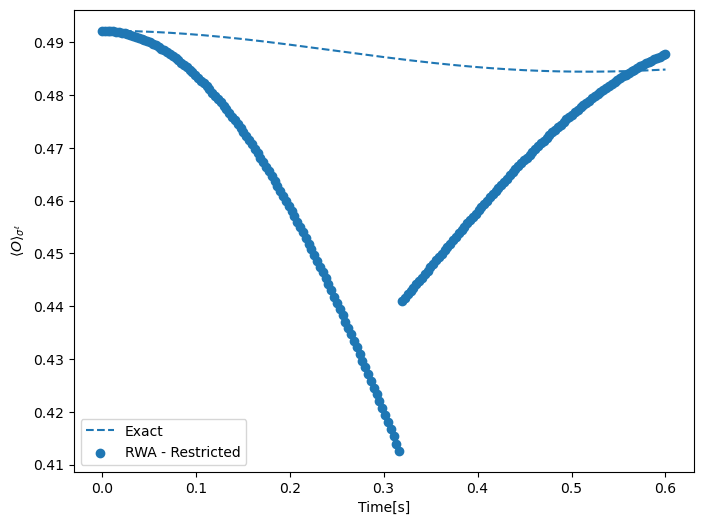

In [34]:
#obs1=spin_ops['sy'][2]*spin_ops['sy'][3]
obs=sz_total
sigma_maxent=[gij.safe_expm_and_normalize(K=Kti) for Kti in Kmaxent]
obs_evex=np.array([(rho*obs).tr() for rho in rhos_XY])
obs_maxent=np.array([(sigmat*obs).tr() for sigmat in sigma_maxent])

fig0,ax0=plt.subplots(figsize=(8,6))
list_of_colors_1=['r','g', 'b']

#Knorms=np.array([linalg.norm(Kex_ti- Kmaxent_ti) for Kex_ti, Kmaxent_ti in zip(resex_XY.states, Kmaxent)])

plt.plot(timespan, obs_evex, label='Exact', linestyle='dashed')
plt.scatter(timespan, obs_maxent, label=r'RWA - Restricted')

#plt.plot(timespan, Knorms)

ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle O \rangle_{\sigma^\ell}$")
plt.show()

In [203]:
HBB1=HBB0+[1j*gij.commutator(HXY, HBB0[-1])]
phid1=np.array(list(phi0)+[.0])
ell_phit, ev_data=solve_restricted_ev(func=func_restricted_ev, generator=HXY, basis=HBB1, phi0=phid1,
                                              tlist=timespan,
                                              fixed_state=sigma0,
                                                        method='linearization')

In [34]:
Tmax=timespan[-1]
ds=[0,1,2,3,4]
all_resrwa, all_evrwa_data=me.multiple_restricted_evs(func=func_restricted_ev, depths=ds, generator=HXY, 
                                            basis0=HBB0, phi0=phi0, tlist=timespan)

all_phits_rwa=[all_evrwa_data["restr_d="+str(d)][0] for d in ds]
all_Kts_rwa=[all_evrwa_data["restr_d="+str(d)][1] for d in ds]
all_sigmas_rwa=[all_evrwa_data["restr_d="+str(d)][2] for d in ds]

→→→ Starting simulation: depth d= 0
→→→ Integration Finalized: The solver successfully reached the end of the integration interval. depth d= 0
→→→ Starting simulation: depth d= 1
→→→ Integration Finalized: The solver successfully reached the end of the integration interval. depth d= 1
→→→ Starting simulation: depth d= 2
→→→ Integration Finalized: The solver successfully reached the end of the integration interval. depth d= 2
→→→ Starting simulation: depth d= 3
→→→ Integration Finalized: The solver successfully reached the end of the integration interval. depth d= 3
→→→ Starting simulation: depth d= 4
→→→ Integration Finalized: The solver successfully reached the end of the integration interval. depth d= 4


In [41]:
params['Jx']

1.5707963267948966

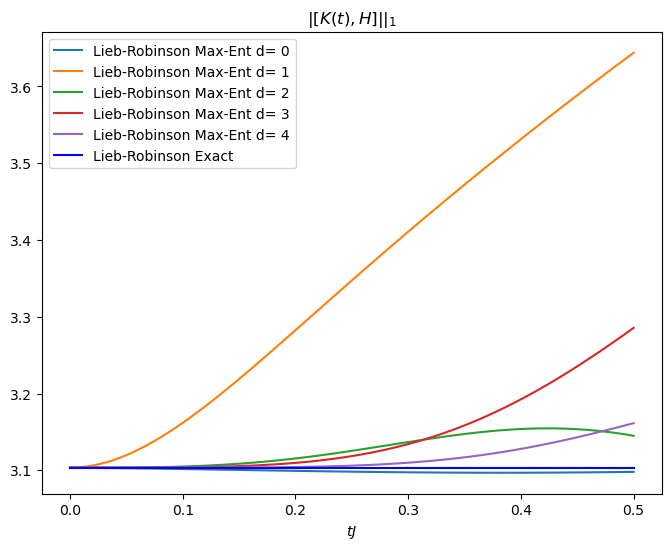

In [44]:
Ob=HXY

lieb_robinson_maxent=[np.array([np.log(linalg.norm(gij.commutator(Kell_ti,Ob))) for Kell_ti in Kt_me_d])for Kt_me_d in all_Kts_rwa]
lieb_robinson=np.array([np.log(linalg.norm(gij.commutator(Kti,Ob))) for Kti in Kt])
fig,ax0=plt.subplots(figsize=(8,6))

for d in ds:
    plt.plot(timespan, lieb_robinson_maxent[ds.index(d)], label='Lieb-Robinson Max-Ent d= ' + str(d))
plt.plot(timespan, lieb_robinson, label='Lieb-Robinson Exact', color='b')
plt.title(f'$|[K(t), H]||_1$')
plt.xlabel(f'$tJ$')
ax0.legend(loc=0)
plt.plot()
plt.show()

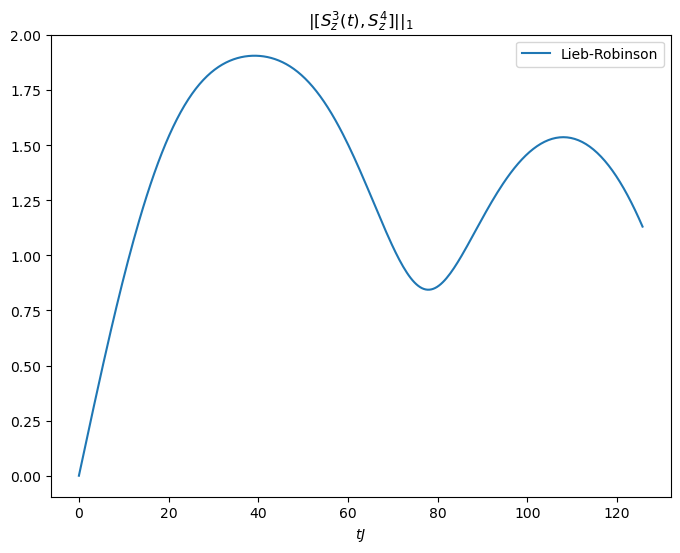

In [55]:
N=300
T=2*np.pi/max(.001,abs(params_XX['Jx']))/N
timespan = np.linspace(0,N*T,N)

Ut=lambda t: (1j*HXY*t).expm()
propagators=[Ut(t=ti) for ti in timespan]
Oa_timet=[prop_Uti.dag() * spin_ops['sz'][3] * prop_Uti for prop_Uti in propagators]
Ob=spin_ops['sz'][4]

lieb_robinson=np.array([linalg.norm(gij.commutator(O_at_timet_ti,Ob)) for O_at_timet_ti in Oa_timet])

fig,ax0=plt.subplots(figsize=(8,6))
plt.plot(timespan, lieb_robinson, label='Lieb-Robinson')
plt.title(f'$|[S_z^3(t), S_z^4]||_1$')
plt.xlabel(f'$tJ$')
ax0.legend(loc=0)
plt.plot()
plt.show()

In [36]:
phit1=all_phits_rwa[0]

phit_alpha=[np.array([phit_timeti[a] for phit_timeti in phit1]) for a in range(0, len(phi0))]

In [37]:
for phi_alpha_timet in phit_alpha:
    phi_fixed=phi_alpha_timet

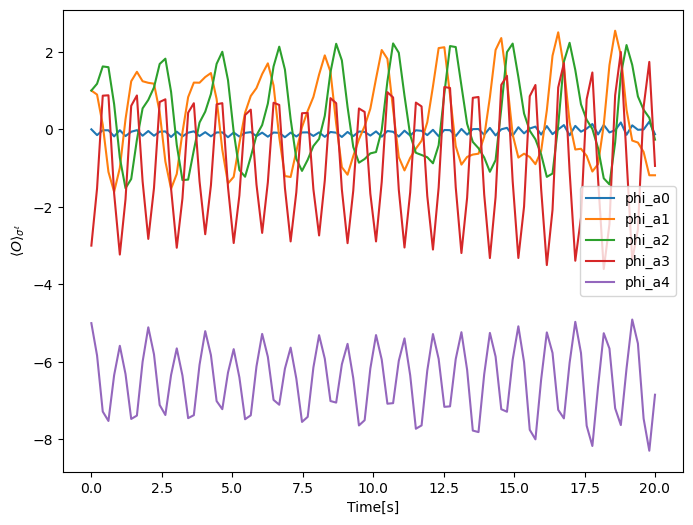

In [38]:

fig0,ax0=plt.subplots(figsize=(8,6))
label=['0','1','2','3','4']

for n in range(0, len(phit_alpha)):
    plt.plot(timespan, phit_alpha[n], label='phi_a' + str(n))

ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle O \rangle_{\sigma^\ell}$")
plt.show()

In [ ]:
all_phits_rwa

In [17]:
strobostopic_states=strobostopic_states_1=[sigma0]+[None for n in range(0, int(Tmax/params['period']),1)]

for t in timespan:
    if strobostopic_states[int(t/params['period'])] is None:
        strobostopic_states[int(t/params['period'])]="fita" + str(int(t/params['period']))

    

In [19]:
strobostopic_states_1

[Quantum object: dims = [[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape = (64, 64), type = oper, isherm = True
 Qobj data =
 [[ 8.47475455e-01+0.00000000e+00j -8.26480879e-02+8.26480879e-02j
   -8.26480879e-02+8.26480879e-02j ...  1.50998431e-04+8.33123847e-05j
    1.50998431e-04+8.33123847e-05j -2.28506215e-05+6.60092543e-06j]
  [-8.26480879e-02-8.26480879e-02j  2.09945755e-02+0.00000000e+00j
    1.61201281e-02+0.00000000e+00j ... -8.59693091e-06-2.97602536e-05j
   -6.60092543e-06-2.28506215e-05j  3.74069590e-06+2.06390420e-06j]
  [-8.26480879e-02-8.26480879e-02j  1.61201281e-02+0.00000000e+00j
    2.09945755e-02+0.00000000e+00j ... -6.60092543e-06-2.28506215e-05j
   -8.59693091e-06-2.97602536e-05j  3.74069590e-06+2.06390420e-06j]
  ...
  [ 1.50998431e-04-8.33123847e-05j -8.59693091e-06+2.97602536e-05j
   -6.60092543e-06+2.28506215e-05j ...  8.20089836e-08+0.00000000e+00j
    6.29684234e-08+0.00000000e+00j -7.99773687e-09+7.99773687e-09j]
  [ 1.50998431e-04-8.33123847e-05j -6.60092543

In [79]:
Tmax/params['period']

2.4541238236909644

In [ ]:
all_res, all_ev_data=me.multiple_restricted_evs(func=func_restricted_ev, depths=ds, generator=generator_magnus1, 
                                            basis0=HBB0, phi0=phi0, tlist=timespan)

all_phits_magnus1=[all_ev_data["restr_d="+str(d)][0] for d in ds]
all_Kts_magnus1=[all_ev_data["restr_d="+str(d)][1] for d in ds]
all_sigmas_magnus1=[all_ev_data["restr_d="+str(d)][2] for d in ds]

In [31]:
resex=qutip.mesolve(H=H,
                    rho0=K0,
                    tlist=timespan,
                    args=params)

rhos_resex=[gij.safe_expm_and_normalize(K=Kt) for Kt in resex.states]

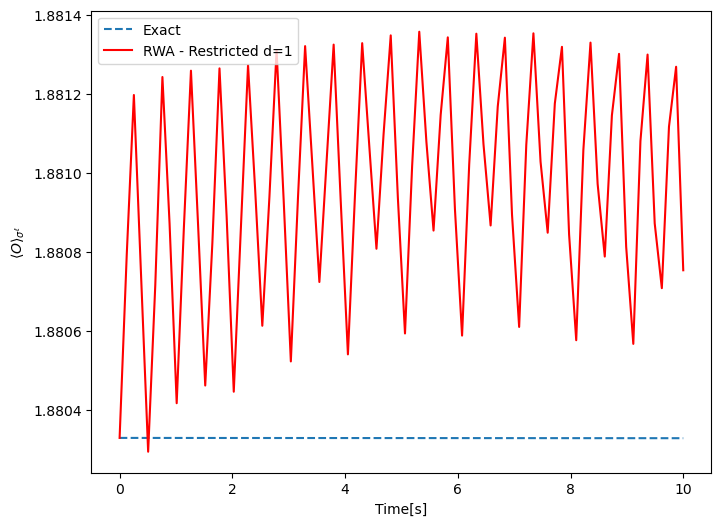

In [34]:
#obs1=spin_ops['sy'][2]*spin_ops['sy'][3]
obs=sz_total

obs_evex=np.array([(rho*obs).tr() for rho in rhos_resex])

obs_maxent=[np.array([(sigmat*obs).tr() for sigmat in restrd_sigmat]) for restrd_sigmat in all_sigmas_rwa]

fig0,ax0=plt.subplots(figsize=(8,6))
list_of_colors_1=['r','g', 'b']
list_of_colors_2=['y','c', 'm']

plt.plot(timespan, obs_evex, label='Exact', linestyle='dashed')
for d in ds: 
    plt.plot(timespan, obs_maxent[ds.index(d)], label=r'RWA - Restricted d='+str(d), color=list_of_colors_1[ds.index(d)])


ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle O \rangle_{\sigma^\ell}$")
plt.show()

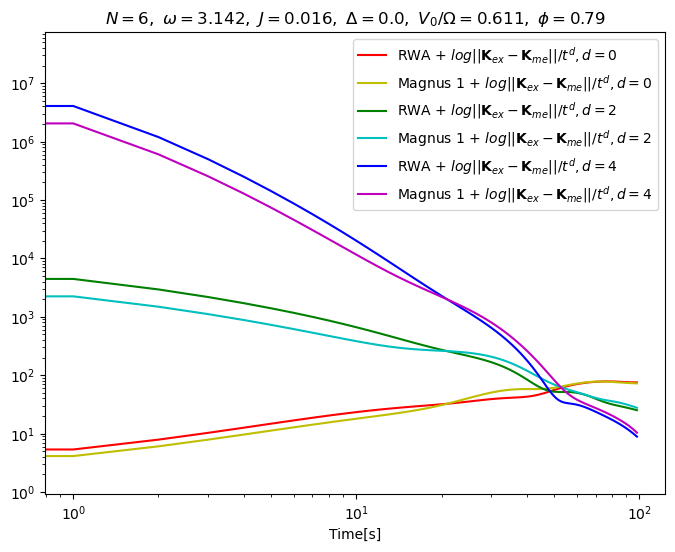

In [55]:
norms_Kex_Kme_rwa=[np.array([linalg.norm(Kex_timeti - Kmaxent_timeti) for Kex_timeti, 
                                                                            Kmaxent_timeti in zip(exact_Ks_rotframe,
                                                                                                          Ks_maxent_di)])
                     for Ks_maxent_di in all_Kts_rwa]

norms_Kex_Kme_magnus1=[np.array([linalg.norm(Kex_timeti - Kmaxent_timeti) for Kex_timeti, 
                                                                            Kmaxent_timeti in zip(exact_Ks_rotframe,
                                                                                                          Ks_maxent_di)])
                     for Ks_maxent_di in all_Kts_magnus1]

#norms_Kex_Kme_magnus2=[np.array([linalg.norm(Kex_timeti - Kmaxent_timeti) for Kex_timeti, 
#                                                                              Kmaxent_timeti in zip(exact_Ks_rotframe,
#                                                                                                          Ks_maxent_di)])
#                     for Ks_maxent_di in all_Kts_magnus2]


log_norm_ex_v_maxent_tI=[np.array([np.real(p)/t**d for p,t in zip(norm_Kex_Kd[1:], timespan[1:])]) for norm_Kex_Kd, d in zip(norms_Kex_Kme_rwa, ds)]
log_norm_ex_v_maxent_magnus1=[np.array([np.real(p)/t**d for p,t in zip(norm_Kex_Kd[1:], timespan[1:])]) 
                              for norm_Kex_Kd, d in zip(norms_Kex_Kme_magnus1, ds)]
#log_norm_ex_v_maxent_magnus2=[np.array([np.real(p)/t**d for p,t in zip(norm_Kex_Kd[1:], timespan[1:])]) 
 #                             for norm_Kex_Kd, d in zip(norms_Kex_Kme_magnus2, ds)]

fig0,ax0=plt.subplots(figsize=(8,6))
for d in ds: 
    plt.plot(log_norm_ex_v_maxent_tI[ds.index(d)], label=r'RWA + $ log ||{\bf K}_{ex} - {\bf K}_{me}||/t^d, d=$'+str(d), color=list_of_colors_1[ds.index(d)])
    plt.plot(log_norm_ex_v_maxent_magnus1[ds.index(d)], label=r'Magnus 1 + $ log ||{\bf K}_{ex} - {\bf K}_{me}||/t^d, d=$'+str(d),
            color=list_of_colors_2[ds.index(d)])
    #plt.plot(log_norm_ex_v_maxent_magnus2[ds.index(d)], label=r'Magnus 2 + $ log ||{\bf K}_{ex} - {\bf K}_{me}||/t^d, d=$'+str(d))
    
ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.xscale('log')
plt.yscale('log')
plt.title(r'$N={},\,\,\omega={},\,\, J={},\,\, \Delta={},\,\, V_0/\Omega={}, \,\, \phi={}$'.format(
                                                                params['size'],
                                                                round(params['omega'],3), 
                                                                round((params['Jx']),3), 
                                                                round(params['omega']-params['Omega'],3), 
                                                                round(params['V0']/params['Omega'],3),
                                                                round(params['phase'],2)))
plt.show()
